**Notebook:** Création d'une baseline pour la tache d'interpretabilité sémantique textuelle

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('drive', force_remount=True)

Mounted at drive


#Chargement données

In [2]:
# import re #Regular expressions operation

def readFile(filename):
    return [line.strip() for line in open(filename)]
#.decode("utf-8")

def readFileWithChunks(filename):
    lines_marked = [line.strip() for line in open(filename)]
    # .decode("utf-8")
    lines_clean1 = [line.replace('[ ', "") for line in lines_marked]
    lines_clean2 = [line.replace(' ]', "") for line in lines_clean1]
    return lines_clean2

In [3]:
path_headline1_chunked = '/content/drive/MyDrive/CENTRALE MARSEILLE/3A/PSTALN/Projet PSTALN/Downloaded files/train_2015_10_22.utf-8/STSint.input.headlines.sent1.chunk.txt'
path_headline2_chunked = '/content/drive/MyDrive/CENTRALE MARSEILLE/3A/PSTALN/Projet PSTALN/Downloaded files/train_2015_10_22.utf-8/STSint.input.headlines.sent2.chunk.txt'
path_headline1 = '/content/drive/MyDrive/CENTRALE MARSEILLE/3A/PSTALN/Projet PSTALN/Downloaded files/train_2015_10_22.utf-8/STSint.input.headlines.sent1.txt'
path_headline2 = '/content/drive/MyDrive/CENTRALE MARSEILLE/3A/PSTALN/Projet PSTALN/Downloaded files/train_2015_10_22.utf-8/STSint.input.headlines.sent2.txt'


sent1_lines = readFileWithChunks(path_headline1_chunked)
sent2_lines = readFileWithChunks(path_headline2_chunked)
sent1_lines_chunked = readFile(path_headline1_chunked)
sent2_lines_chunked = readFile(path_headline2_chunked)

Train Test split

In [4]:
trainSamples = sent1_lines
trainSamplesChunked = sent1_lines_chunked

testSamples = sent2_lines
testSamplesChunked = sent2_lines_chunked

print('Train size:', len(trainSamples))
print('Test size:', len(testSamples))

Train size: 756
Test size: 756


#Embeddings

Chargement d'Embeddings préentrainés de type GloVe pour obtenir des représentation des mots de notre dataset

GloVe embedding

In [5]:
# file = open('glove.twitter.27B.200.txt', encoding='utf-8') #Fichier à télécharger sur https://nlp.stanford.edu/projects/glove/

# for line in file:
#     values = line.split()
#     word = values[0]
#     vectors = np.sarray(values[1:])
#     glove_vectors(word) = vectors
# file.close()

FastText embedding

In [6]:
#Télécharger le model pour le français sur https://fasttext.cc/docs/en/crawl-vectors.html au format texte

# import io

# def load_vectors(fname):
#     fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
#     n, d = map(int, fin.readline().split())
#     data = {}
#     for line in fin:
#         tokens = line.rstrip().split(' ')
#         data[tokens[0]] = map(float, tokens[1:])
#     return data

#####Création Embeddings
Inspiré de : https://keras.io/examples/nlp/pretrained_word_embeddings/

In [7]:
#On suppose que l'embedding est disponible (voire préentrainé si possible) : cf Mouss

import numpy as np
import tensorflow as tf
from tensorflow import keras

Creation vocabulaire indexes

In [8]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(trainSamples).batch(128)
vectorizer.adapt(text_ds)

In [9]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'in', 'to', 'on']

In [10]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]
#Dans cette phrase test : 3 mots ne font pas partie du voc de notre db et sont donc '<UNK>'

array([17,  1,  1,  4, 17,  1])

In [11]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [12]:
# test = ["the", "cat", "sat", "on", "the", "mat"]
# [word_index[w] for w in test]

Download GloVe embeddings

In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-01-05 22:45:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-05 22:45:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-05 22:45:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [14]:
!ls
!unzip -q glove.6B.zip

drive  glove.6B.zip  sample_data


In [15]:
# path_to_glove_file = os.path.join(
#     os.path.expanduser("~"), ".keras/datasets/glove.6B.100d.txt"
# )
path_to_glove_file = '/content/glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [16]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 2075 words (58 misses)


#Chunking

####Preprocessing

> y_train / y_test

#####BIO Encoding

In [17]:
def removeNoise(line):
    noiseTokens = ['[', ']', ',', '.', ':', ';', '"', "'", "''", "`", "-",]
    for token in noiseTokens:
      line = line.replace(token, "")
    return line


def chunkedLine2ListChunks(line):
  line = removeNoise(line)
  line = line.split('  ') #Ca c'est de la bidouille mais ça marchera eheh
  for chunk in line:
    if len(chunk)==0: 
      while chunk in line:
        del line[line.index(chunk)]
  return line


def isInsideChunk(word, chunk):
  """
  Returns True if word have to be encoded as a O (BIO)
  Else False
  """
  return word in chunk

# ex = sent1_lines_chunked[0]
# l = chunkedLine2ListChunks(ex)
# print("Nazi" in l[0])
# print(isInsideChunk("Nazi", l[0]))


def isFirstChunkWord(word, chunk):
  """
  On suppose que le mot est présent dans le chunk

  Returns True if word have to be encoded as a B (BIO)
  Else False if word have to be encoded as a I (BIO)
  """
  chunk = chunk.split()
  return chunk[0] == word

# isFirstChunkWord("Nazi", l[0])

def wordBIOencoding(word, chunk):
  if isInsideChunk(word, chunk):
    if isFirstChunkWord(word, chunk): return 'B'
    else : return 'I'
  else : return 'O'

def sentenceBIOencoding(line, chunkedLine):
  '''
  La pertinence du 'O' n'est pas évidente ici étant donné que tous les mots de line semblent faire partie d'un chunk de chunkedLine
  '''

  words = line.split()
  chunks = chunkedLine2ListChunks(chunkedLine)
  BIOcodes = []

  currentChunk = 0

  for word in words:
    code = wordBIOencoding(word, chunks[currentChunk])

    if code == 'O':
      if currentChunk+1<len(chunks):
        currentChunk+=1 #Attention on explore le chunk suivant (si jamais c'est le début d'un autre chunk)
        test_code = wordBIOencoding(word, chunks[currentChunk])
        if test_code == 'B':
          code = test_code

    BIOcodes.append(code)
  return BIOcodes


# for idx in range(3):
#   ex = sent1_lines_chunked[idx]
#   print(ex)
#   l = chunkedLine2ListChunks(ex)
#   print(l)
#   print()


# nbSamples = 3 #len(sent1_lines)
# for line, chunkedLine in zip(sent1_lines[:nbSamples], sent1_lines_chunked[:nbSamples]):
#   BIOcodes = sentenceBIOencoding(line, chunkedLine)
#   print(line.split())
#   print(BIOcodes)
#   print(chunkedLine)
#   print()

In [18]:
BIO_y_train = []  #Contains BIO codes
BIO_y_test = []

nbSamples = len(trainSamples)
for line, chunkedLine in zip(trainSamples[:nbSamples], trainSamplesChunked[:nbSamples]):
    BIOcodes = sentenceBIOencoding(line, chunkedLine)
    BIO_y_train.append(BIOcodes)

nbSamples = len(testSamples)
for line, chunkedLine in zip(testSamples[:nbSamples], testSamplesChunked[:nbSamples]):
    BIOcodes = sentenceBIOencoding(line, chunkedLine)
    BIO_y_test.append(BIOcodes)

print(len(trainSamples), len(BIO_y_train))
print(trainSamplesChunked[0])
print(BIO_y_train[0])

756 756
[ Former Nazi death camp guard Demjanjuk ] [ dead ] [ at 91 ]
['B', 'I', 'I', 'I', 'I', 'I', 'B', 'B', 'I']


#####Conversion caractères BIO en entiers

In [19]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
labelEncoder.fit(['B', 'I', 'O'])
print(labelEncoder.transform(['B', 'I', 'O']))

[0 1 2]


In [20]:
BIO_int_y_train = []
BIO_int_y_test = []

for line in BIO_y_train:
  BIO_int_y_train.append(labelEncoder.transform(np.array(line)))

for line in BIO_y_test:
  BIO_int_y_test.append(labelEncoder.transform(np.array(line)))

print(trainSamplesChunked[0])
print(BIO_y_train[0])
print(BIO_int_y_train[0])

[ Former Nazi death camp guard Demjanjuk ] [ dead ] [ at 91 ]
['B', 'I', 'I', 'I', 'I', 'I', 'B', 'B', 'I']
[0 1 1 1 1 1 0 0 1]


#####Conservion One Hot 

In [21]:
from keras.utils import np_utils

y_train = []  #One hot encoded
y_test = []

for line in BIO_int_y_train:
  y_train.append(np_utils.to_categorical(line, num_classes=3))

for line in BIO_int_y_test:
  y_test.append(np_utils.to_categorical(line, num_classes=3))

print(trainSamplesChunked[0])
print(BIO_y_train[0])
print(BIO_int_y_train[0])
print(y_train[0])

[ Former Nazi death camp guard Demjanjuk ] [ dead ] [ at 91 ]
['B', 'I', 'I', 'I', 'I', 'I', 'B', 'B', 'I']
[0 1 1 1 1 1 0 0 1]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


#####Conversion format input X

In [22]:
def preprocessLines(lines):
  return np.array(vectorizer(np.array([[s] for s in lines])))

x_train = preprocessLines(trainSamples)
x_test = preprocessLines(testSamples)

print(x_train.shape)
print(x_test.shape)

(756, 200)
(756, 200)


#####Conversion format input Y

> On complète le nombre de prédictions attendues pour en avoir le même nombre que de môts dans un sample de X (paddings INCLUS)

In [23]:
predictionForPaddingWord = [0, 0, 2]  # = 'O'
lenSentence = x_train.shape[1]

def completeLineLabels(lineLabels, lenSentence):
  '''
  Add 'O' labels for Padding words
  '''
  nbWordsInSample = len(lineLabels)
  nbPaddingLabelsToAdd = lenSentence-nbWordsInSample

  paddingLabels = np.array([predictionForPaddingWord for i in range(nbPaddingLabelsToAdd)])
  lineLabels = np.concatenate((lineLabels,paddingLabels))

  return lineLabels

#Test
y = np.array(completeLineLabels(y_train[0], 200))
print(y.shape)

(200, 3)


In [24]:
y_train = np.array([np.array(completeLineLabels(line_labels, lenSentence)) for line_labels in y_train])
y_test = np.array([np.array(completeLineLabels(line_labels, lenSentence)) for line_labels in y_test])

print(y_train.shape)
print("Sample size", y_train[0].shape)

(756, 200, 3)
Sample size (200, 3)


####Modèle tagging : Simple RNN

In [25]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding, Input

nbClasses = 3 #BIO

# SimpleRNN model
model = Sequential()
model.add(Input(shape=(None,), dtype="int64"))  #integer_sequences_input
model.add(Embedding(
    input_dim=num_tokens, #Size of the vocabulary
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False #Don't want to update embeddings
                    ))
model.add(SimpleRNN(units=nbClasses, #dim hidden state returned
                    activation="softmax", 
                    return_sequences=True
                    )) #return_sequences=False pour obtenir uniquement la derniere couche RNN

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         213500    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 3)           312       
                                                                 
Total params: 213,812
Trainable params: 312
Non-trainable params: 213,500
_________________________________________________________________


Entrainement

In [26]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2, validation_data=(x_test, y_test))

Epoch 1/50
24/24 - 3s - loss: 1.6611 - acc: 0.9772 - val_loss: 1.5779 - val_acc: 0.9772 - 3s/epoch - 135ms/step
Epoch 2/50
24/24 - 1s - loss: 1.5167 - acc: 0.9792 - val_loss: 1.4503 - val_acc: 0.9778 - 1s/epoch - 58ms/step
Epoch 3/50
24/24 - 1s - loss: 1.3939 - acc: 0.9801 - val_loss: 1.3330 - val_acc: 0.9785 - 1s/epoch - 57ms/step
Epoch 4/50
24/24 - 1s - loss: 1.2802 - acc: 0.9808 - val_loss: 1.2241 - val_acc: 0.9789 - 1s/epoch - 56ms/step
Epoch 5/50
24/24 - 1s - loss: 1.1747 - acc: 0.9816 - val_loss: 1.1232 - val_acc: 0.9796 - 1s/epoch - 56ms/step
Epoch 6/50
24/24 - 1s - loss: 1.0772 - acc: 0.9824 - val_loss: 1.0301 - val_acc: 0.9802 - 1s/epoch - 56ms/step
Epoch 7/50
24/24 - 1s - loss: 0.9873 - acc: 0.9830 - val_loss: 0.9444 - val_acc: 0.9805 - 1s/epoch - 55ms/step
Epoch 8/50
24/24 - 1s - loss: 0.9047 - acc: 0.9833 - val_loss: 0.8658 - val_acc: 0.9807 - 1s/epoch - 55ms/step
Epoch 9/50
24/24 - 1s - loss: 0.8289 - acc: 0.9836 - val_loss: 0.7938 - val_acc: 0.9812 - 1s/epoch - 55ms/step


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


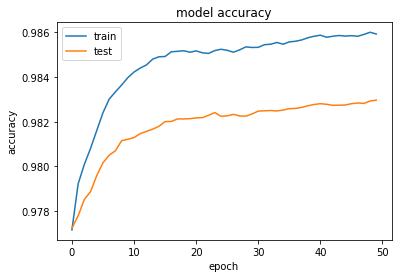

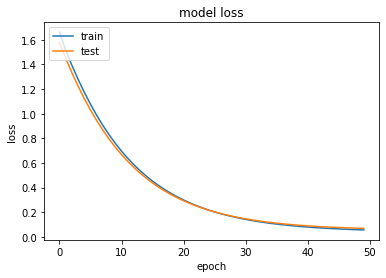

In [27]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

####Evaluation

In [28]:
def getBatchAccuracy(y_pred, y_true):
  '''
  Input
  -----
  Batch labels hot encoded of dimension batch_size x 200 x 3
  '''
  assert len(y_pred.shape) == len(y_true.shape) == 3 

  sum_acc = 0
  for i in range(len(y_pred)):
    sum_acc += getSampleAccuracy(y_pred[i], y_true[i])  #Attention ici on ne défini pas une prédiction de chunking de phrase uniquement comme correcte ou non, mais possiblement partiellement correcte
  return sum_acc / len(y_pred)


def getSampleAccuracy(y_sample_pred, y_sample_true):
  '''
  Input
  -----
  Sentence/Sample labels hot encoded of dimension 200 x 3
  '''
  assert len(y_sample_pred.shape) == len(y_sample_true.shape) == 2

  pred_labels_integers = np.argmax(y_sample_pred, axis=1)
  true_labels_integers = np.argmax(y_sample_true, axis=1)

  true_counts = 0
  for i in range(len(pred_labels_integers)):
    if true_labels_integers[i] == pred_labels_integers[i]:
      true_counts +=1
  return true_counts/len(pred_labels_integers)

In [29]:
y_pred = model.predict(x_test)

acc = getBatchAccuracy(y_pred=y_pred, y_true=y_test)
print(acc)

0.9829629629629723


####Chunking : Construction de phrases 'chunkées' à partir de phrases non-chunkées

In [30]:
def startChunk(word):
  return '[ ' + word

def endChunk(word):
  return word + ' ]'

def chunkLine(line, line_labels_integers, showErrors):

  new_line = line.split()
  previous_label = -1

  i = -1
  for word, label in zip(
                        line.split(),
                        line_labels_integers[:len(line.split())]
                        ):
    i +=1
    if label == 0:  #"B"
      new_line[i] = startChunk(word)
      if previous_label == 1 or previous_label == 0:
        new_line[i-1] = endChunk(new_line[i-1])
      previous_label = 0

    if label == 2:  #'O'
      if previous_label == 0 or previous_label== 1:
        new_line[i-1] = endChunk(new_line[i-1])
      previous_label = 2

    if label == 1 : #'I'
      if previous_label == 2: 
        if showErrors : print(f"Oups il y a eu une erreur de classification du mot '{word}' dans la phrase \n {line}\n")
      if previous_label == -1:  #Problème de prédiction d'un I en début de phrase pour des noms propres ...
        if showErrors : print(f"Erreur début de phrase : '{word}'\n {line}\n")
        new_line[i] = startChunk(word)  #TODO : améliorer
      previous_label = 1

    if i == len(line.split()) - 1:  #Fin de phrase
      if label == 0 or label == 1: # 'B' ou 'I'
        new_line[i] = endChunk(word)
    
  separator = ' '
  new_line = separator.join(new_line)
  return new_line

def chunkDataset(lines, showErrors=False):

  #Preprocess 'lines' pour prédictions
  x= preprocessLines(lines)

  y_pred = model.predict(x)
  lines_labels_integers = np.argmax(y_pred, axis=2)

  chunkedLines = []

  for line, line_labels_integers in zip(lines, lines_labels_integers):
    chunkedLines.append(chunkLine(line, line_labels_integers, showErrors))

  return chunkedLines

In [31]:
chunkedLines = chunkDataset(testSamples, showErrors=False)
nb = 3

#Pour affichage uniquement
x= preprocessLines(testSamples)
y_pred = model.predict(x)
lines_labels_integers = np.argmax(y_pred, axis=2)

for line, trueChunkedLine, chunkedLine, lineLabels in zip(testSamples[:nb], testSamplesChunked[:nb], chunkedLines[:nb], lines_labels_integers[:nb]):
  print('Line : \t\t\t\t', line)
  print('True chunked line : \t\t', trueChunkedLine)
  print('Predicted chunked line : \t', chunkedLine)
  print('Predicted labels : \t\t', lineLabels[:len(line.split())])
  print()

Line : 				 John Demjanjuk , convicted Nazi death camp guard , dies aged 91
True chunked line : 		 [ John Demjanjuk ] [ , ] [ convicted Nazi death camp guard ] [ , ] [ dies ] [ aged 91 ]
Predicted chunked line : 	 [ John Demjanjuk ] [ , convicted ] [ Nazi death camp ] [ guard ] , dies aged 91
Predicted labels : 		 [1 1 0 1 0 1 1 0 2 2 2 2]

Line : 				 Saudi Women Allowed To Compete At Olympics
True chunked line : 		 [ Saudi Women ] [ Allowed ] [ To Compete ] [ At Olympics ]
Predicted chunked line : 	 [ Saudi ] [ Women ] Allowed [ To Compete ] [ At Olympics ]
Predicted labels : 		 [0 0 2 0 1 0 1]

Line : 				 Drone strike kills four suspected militants in Pakistan
True chunked line : 		 [ Drone strike ] [ kills ] [ four suspected militants ] [ in Pakistan ]
Predicted chunked line : 	 [ Drone strike ] [ kills ] [ four ] [ suspected militants ] [ in Pakistan ]
Predicted labels : 		 [0 1 0 0 0 1 0 1]



#Alignement

In [ ]:
import pandas as pd 
import numpy as np
from math import *

def norm(x):
    norm=0
    for elt in x:
        norm+=elt**2
    norm=sqrt(norm)
    return(norm)

def similarity(x,y):
    sim=np.dot(x, y)
    sim=sim/(norm(x)*norm(y))
    return(sim)

#Hungarian Algorithm (a.k.a. the Kuhn-Munkres algorithm) sur 2 chunks : aligner mots pour meilleur score possible
from scipy.optimize import linear_sum_assignment

def alignment_mots(chunk_1, chunk_2):
    if len(chunk_2)<len(chunk_1): ##If more rows than columns, not every row needs to be assigned to a column, and vice versa.
    #Toujours prendre plus petit chunk comme premier chunk !!!!
        a, b=chunk_2, chunk_1
    else:
        a, b=chunk_1, chunk_2
    cost=[]
    for i in range (len(a)): #chunk_1
        inter=[]
        for j in range(len(b)): #chunk_2
            inter.append(similarity(a[i], b[j])) #chunk_1[i], chunk_2[j]
        cost.append(inter)
    cost=np.array(cost)
    #print(cost)

    row_ind, col_ind = linear_sum_assignment(-cost) #- car linear_sum_assignment minimise normalement
    sim=cost[row_ind, col_ind].sum() #score de similarité entre 2 chunks
    return(sim) #col_ind, #col_ind donne alignement des mots pour obtenir meilleur score de similarité possible
 
def min_max_scaler(sim):
    scaled=[]
    a, b=np.max(sim), np.min(sim)
    for elt in sim:
        inter=(elt-b)/(a-b)
        inter=inter*5 #Pour avoir des scores entre 0 et 5
        inter=round(inter) #Pour avoir des scores entiers
        scaled.append(inter)
    return(scaled)

#Hungarian Algorithm (a.k.a. the Kuhn-Munkres algorithm) : aligner chunks pour meilleur score possible de phrase 

def alignment_chunks(sentence_1, sentence_2):
    cost=[]
    if len(sentence_2)<len(sentence_1): ##If more rows than columns, not every row needs to be assigned to a column, and vice versa.
        #Toujours prendre plus petite sentence comme première sentence !!!!
        a, b=sentence_2, sentence_1
        inv=True
    else:
        a, b=sentence_1, sentence_2
        inv=False

    for i in range (len(a)):
        inter=[]
        for j in range(len(b)):
            sim=alignment_mots(a[i], b[j])        
            inter.append(sim)
        cost.append(inter)
    cost=np.array(cost)

    #Possibilité amélioration : Normalize chunk similarity by number of tokens in shorter chunk 
    #such that it assigned higher scores to pairs of chunks such as physician and general physician.

    row_ind, col_ind = linear_sum_assignment(-cost) #- car linear_sum_assignment minimise normalement
    sim=cost[row_ind, col_ind] #Liste de score de similarité pour chaque alignement optimal de chunks

    if inv:
        row_ind, col_ind=col_ind, row_ind

    #sim=min_max_scaler(sim) => PEUT ETRE FAIRE MIN MAX SCALER SUR CORPUS PLUS GRAND QUE 2 PHRASES ?? PB SI 2 PHRASES TRES DIFF
    #print(sim) #print(row_ind, col_ind)

    list_couples_chunks_et_score=[]
    for i in range(len(sim)):
        list_couples_chunks_et_score.append((row_ind[i], col_ind[i], sim[i]))
    return(list_couples_chunks_et_score)

In [ ]:
def create_list_of_embedded_chunks_exploitable_for_alignement(chunked_sentence):
  list_sentence=[]
  chunk=''
  for i in range(len(chunked_sentence)):
    elt=chunked_sentence[i]
    if elt!='[' or elt !=']' or elt!=' ':
      chunk+=elt
    if elt==']':
      chunk=removeNoise(chunk)
      list_sentence.append(chunk)
      chunk=''

  list_sentence_embedded=[]
  for elt in list_sentence:
    inter=elt.split(' ')
    inter_copy=inter[:] #inter without '
    for elt_bis in inter_copy:
      if elt_bis=='':
        inter_copy.remove(elt_bis)
    inter_embedded=[]
    for elt_ter in inter_copy:
      elt=vectorizer(elt_ter)
      elt=elt.numpy()
      elt=list(elt)
      if len(elt)!=0:
        inter_embedded.append(elt)
    list_sentence_embedded.append(inter_embedded)

  return(list_sentence_embedded)

In [ ]:
#Certaines sentences ne fonctionnent pas => Pourquoi ?
n= 10#len(testSamplesChunked)

n_failed=0

for i in range(n-1):
  for j in range(i+1,n):
    try:

      sentence_1=testSamplesChunked[i]
      sentence_2=testSamplesChunked[j]

      sentence_a=create_list_of_embedded_chunks_exploitable_for_alignement(sentence_1)
      sentence_b=create_list_of_embedded_chunks_exploitable_for_alignement(sentence_2)

      print(alignment_chunks(sentence_a, sentence_b))
    except:
      n_failed+=1
      pass

In [ ]:
nb_couples=n*(n+1)*0.5
print(n_failed/nb_couples) #Proportions de combinaisons ne fonctionnant pas 